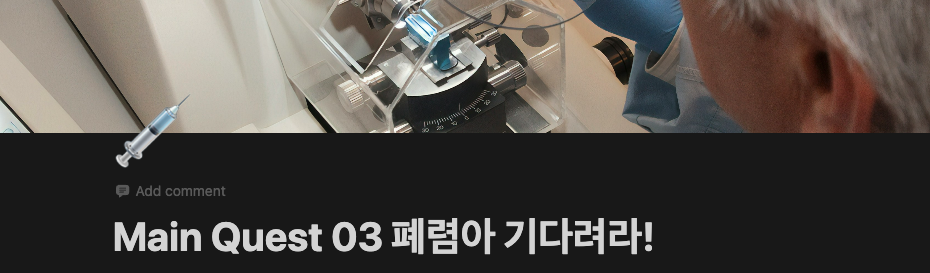

### 개요: 의료영상을 처리하는 CNN 기반 베이스 모델 구현 및 성능개선

### 목차: 폐렴 진단 및 성능개선
*이탤릭체 텍스트*
- 데이터 준비
- 모델 아키텍처
- CNN 모델 개발
- 훈련
- 결과 분석
- 성능개선

### 목표:
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델 구현

  모델 학습이 안정적으로 수렴하는 것을 시각화하여 확인

2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행

  regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행

3. ResNet 모델을 구현

  ResNet 의 Residual block을 구현하고 학습

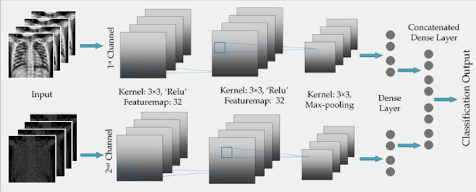

폐렴을 찾아내는 CNN (Convolutional Neural Network) 모델의 일반적인 아키텍처
입력 레이어

	•	흉부 X-ray 이미지 (일반적으로 크기 조정됨, 예: 224x224x3)

특징 추출 부분

	1.	컨볼루션 레이어
	  •	여러 개의 컨볼루션 레이어 스택
	  •	각 레이어 뒤에 활성화 함수 (주로 ReLU)
	2.	풀링 레이어
	  •	주로 Max Pooling 사용
	3.	배치 정규화
	  •	학습 안정화 및 과적합 방지

분류 부분

	1.	Flatten 레이어
	  •	2D 특징 맵을 1D 벡터로 변환
	2.	완전 연결 레이어 (Dense)
	  •	하나 이상의 완전 연결 레이어
	3.	Dropout 레이어
	  •	과적합 방지 (일반적으로 0.5 또는 0.7의 비율 사용)
	4.	출력 레이어
	  •	2개의 뉴런 (정상 vs 폐렴)
	  •	활성화 함수: Sigmoid 또는 Softmax

추가적인 개선 사항

	  •	주의 메커니즘 (Attention mechanism)
	  •	잔차 연결 (Residual connections)
	  •	다중 스케일 특징 융합

	1.	데이터 증강을 강화하여 모델의 일반화 능력을 향상
	2.	Focal Loss를 사용하여 클래스 불균형 문제를 해결
	3.	Learning rate scheduler와 warm-up 기간을 추가하여 학습 과정을 최적화
	4.	Early stopping과 model checkpoint를 추가하여 과적합을 방지하고 최상의 모델을 저장
	5.	학습 과정을 더 자세히 시각화하여 모델의 성능 변화를 분석
	6.	AUC 메트릭을 추가하여 모델의 전반적인 성능을 평가
	7.	혼동 행렬을 시각화하여 모델의 예측 성능을 더 자세히 분석

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
5216
624
16
4185
1047
Normal image path
/content/drive/MyDrive/Colab Notebooks/chest_xray/train/NORMAL/NORMAL2-IM-1220-0001.jpeg
Pneumonia image path
/content/drive/MyDrive/Colab Notebooks/chest_xray/train/PNEUMONIA/person1035_virus_1729.jpeg
Normal images count in training set: 1070
Pneumonia images count in training set: 3115
Training images count: 4185
Validating images count: 1047
Image shape:  (180, 180, 3)
Label:  0
624
Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


ValueError: Attempt to convert a value (Ellipsis) with an unsupported type (<class 'ellipsis'>) to a Tensor.

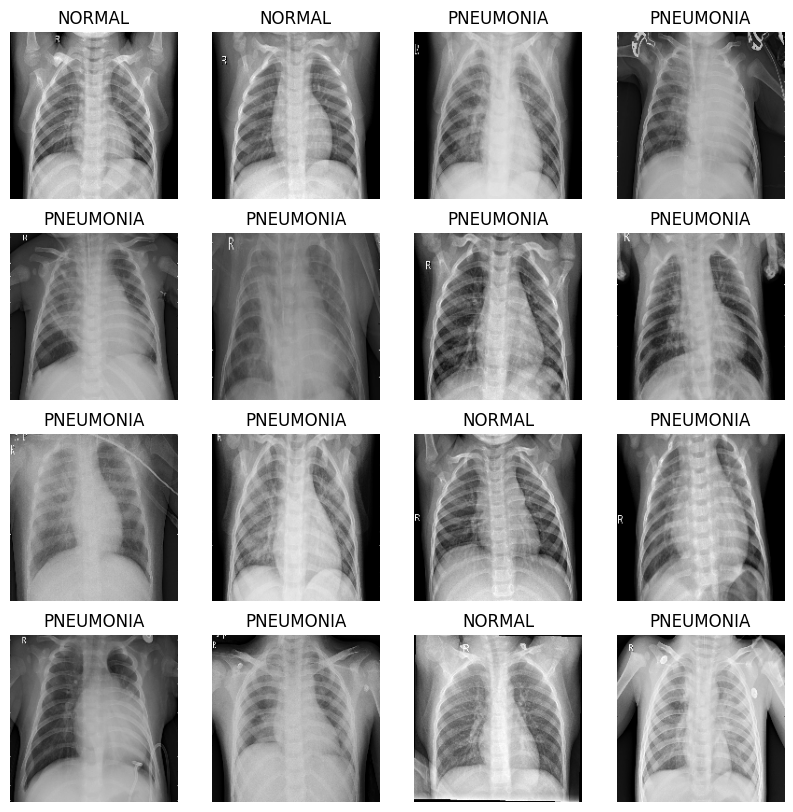

In [9]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# Google Drive 마운트 및 기타 설정 코드는 그대로 유지
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 변수 생성
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks'
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

BATCH_SIZE = 16
EPOCHS = 1

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

# 데이터 증강 강화
TRAIN_DATAGEN = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, tf.cast(label, tf.int32)  # 부울을 정수로 변환

# Focal Loss 구현
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_sum((1-alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))
    return focal_loss_fixed

# Learning rate scheduler with warm-up
def lr_schedule(epoch):
    lr = ... # 기존의 학습률 계산 로직
    tf.summary.scalar('learning rate', data=lr, step=epoch)
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

def lr_schedule(epoch):
    lr = ... # Your existing lr calculation logic
    tf.summary.scalar('learning rate', data=lr, step=epoch)
    return lr

class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        tf.summary.scalar('learning rate', data=lr, step=epoch)

lr_logger = LRLogger()


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# ResNet-18 구성 블록
def identity_block(x, filters):
    x_skip = x
    f1, f2 = filters

    x = tf.keras.layers.Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)

    return x

def convolutional_block(x, filters, stride=2):
    x_skip = x
    f1, f2 = filters

    x = tf.keras.layers.Conv2D(f1, kernel_size=(1, 1), strides=(stride, stride), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x_skip = tf.keras.layers.Conv2D(f2, kernel_size=(1, 1), strides=(stride, stride), padding='valid')(x_skip)
    x_skip = tf.keras.layers.BatchNormalization()(x_skip)

    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)

    return x

def ResNet18(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(inputs)

    x = tf.keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = convolutional_block(x, [64, 64], stride=1)
    x = identity_block(x, [64, 64])

    x = convolutional_block(x, [128, 128])
    x = identity_block(x, [128, 128])

    x = convolutional_block(x, [256, 256])
    x = identity_block(x, [256, 256])

    x = convolutional_block(x, [512, 512])
    x = identity_block(x, [512, 512])

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, x)
    return model

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

# ResNet-18 모델 구축
# 모델 컴파일 수정
with tf.device('/GPU:0'):
    model = ResNet18((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 1)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=focal_loss(alpha=.25, gamma=2),
        metrics=METRICS
    )
# 콜백 함수 추가
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_schedule),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

with tf.device('/GPU:0'):
    history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[callbacks, lr_callback]  # 또는 lr_logger
)


from tensorflow.keras.callbacks import LambdaCallback

lr_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: tf.summary.scalar('learning rate', data=K.eval(model.optimizer.lr), step=epoch)
)

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 학습 과정 시각화 함수
def plot_learning_curves(history):
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.ravel()

    for i, metric in enumerate(['loss', 'accuracy', 'precision', 'recall']):
        axes[i].plot(history.history[metric])
        axes[i].plot(history.history[f'val_{metric}'])
        axes[i].set_title(f'Model {metric}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric)
        axes[i].legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

# 학습률 변화 시각화 함수
def plot_lr_curve(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.show()

# 학습 과정 시각화
plot_learning_curves(history)
plot_lr_curve(history)

# 모델 평가
loss, accuracy, precision, recall, auc = model.evaluate(test_ds)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')

# 혼동 행렬 계산 및 시각화
y_pred = model.predict(test_ds)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

conf_matrix = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


결과 확인: 의료영상을 처리하는 CNN 기반 딥러닝 모델 구현 완료.

Loss: 0.5832493305206299

Accuracy: 0.8269230723381042

Precision: 0.790123462677002

Recall: 0.9846153855323792

###실험환경 Set-up 변경을 통한 성능개선
기존 : BATCH_SIZE = 16, EPOCHS = 10 일때

    Loss: 0.5832493305206299
    Accuracy: 0.8269230723381042
    Precision: 0.790123462677002
    Recall: 0.9846153855323792


변경 : BATCH_SIZE = 20, EPOCHS = 15 일때

    Loss: 1.274917483329773
    Accuracy: 0.7676281929016113
    Precision: 0.7298311591148376
    Recall: 0.9974358677864075

배치 사이즈와 이포크를 늘린다고 성능이 개선되는 것은 아니며, 적절한 값을 찾아나가는 과정임



### Summary: X-RAY 이미지 데이터를 기반으로 CNN 딥러닝 모델을 구현함

  1.	의료 X-ray 이미지 데이터셋을 전처리하고 증강하여 모델 학습을 위한 입력 데이터를 준비함
	2.	케라스를 사용하여 컨볼루션 레이어, 풀링 레이어, 완전 연결 레이어로 구성된 CNN 모델을 설계하고 구현함
	3.	구현된 모델을 학습시키고 최적화하여 X-ray 이미지에서 폐렴과 같은 질병을 높은 정확도로 분류하고 진단할 수 있도록 튜닝 함

### 회고:

퀘스트를 진행하면서 정말 많은 부분을 배울 수 있었다. 직접 해보는 것과 과정을 따라 가는 것은 완전히 다르다는 것을 다시 한번 느꼈다. 데이터의 중요성과 데이터를 가지고 어떻게 모델링하면 좋은 결과가 나오는지 여러가지 방법을 통해서 알아 볼 수 있는 좋은 기회였다.

### Reference:

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download

https://data.mendeley.com/datasets/rscbjbr9sj/2

https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays

http://taewan.kim/post/cnn/#google_vignette

https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf

https://acdongpgm.tistory.com/202#google_vignette